# Diabetes prediction using Random Forest Model

## 1. Import Modules 

In [30]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

import configuration as config
import functions as funcs

## 2. Data preparation

### 2.1. Download data from disk (re-use stored data)

In [31]:
with open(config.DATA_FILE, 'rb') as input_file:
    dataset=pickle.load(input_file)

training_df=dataset['training']
testing_df=dataset['testing']

### 2.2. Inspect

In [32]:
training_df.head().T

,10,529,131,187,409
Pregnancies,0.334934,-1.566076,1.352026,-0.816164,-0.816164
Glucose,-0.293618,-0.256546,0.131348,0.328947,1.558734
BloodPressure,1.652016,-0.594673,-1.364645,2.141666,-0.339985
SkinThickness,0.197164,-0.921240,0.342364,1.187308,1.874368
Insulin,0.117969,0.184841,-0.093278,-1.282178,2.464979
BMI,0.782201,-1.231117,0.194540,0.003813,1.371107
DiabetesPedigreeFunction,-1.107618,0.915921,1.587144,1.757621,1.005444
Age,0.096393,0.205657,0.398657,0.398657,-0.154282
Outcome,0.000000,0.000000,1.000000,1.000000,1.000000


## 3. Baseline model

In [33]:
model=RandomForestClassifier()
model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
accuracy=accuracy_score(model.predict(training_df.drop('Outcome', axis=1)), training_df['Outcome'])*100
print(f'Random forest model accuracy: {accuracy:.1f}%')

Random forest model accuracy: 100.0%


In [34]:
cross_val_scores={
    'Model': [],
    'Score': []
}

scores=cross_val_score(
    model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=7,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['Baseline']*len(scores))
cross_val_scores['Score'].extend(scores)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 74.5 +/- 3.1%


## 4. Hyperparameter optimization

### 4.1. Hyperparameter grid search

In [35]:
%%time

hyperparameters={
    'n_estimators':[2,5,10,20],
    'criterion':['gini','entropy','log_loss'],
    'max_depth':[2,5,10,15],
    'min_weight_fraction_leaf':[0.005,0.01,0.02],
    'max_features':[0.5,0.6,0.7,0.8],
    'min_impurity_decrease':[0.0005,0.001,0.002],
    'ccp_alpha':[0,10**-7,10**-6,10**-5]
}

search=GridSearchCV(
    RandomForestClassifier(),
    hyperparameters,
    return_train_score=True,
    scoring='accuracy',
    cv=7,
    n_jobs=-1
)

search_results=search.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
model=search_results.best_estimator_
hyperparameters=search_results.best_params_

print('Best hyperparameters:\n')

for key, value in hyperparameters.items():
    print(f' {key}: {value}')

print()


Best hyperparameters:

 ccp_alpha: 1e-07
 criterion: log_loss
 max_depth: 5
 max_features: 0.8
 min_impurity_decrease: 0.002
 min_weight_fraction_leaf: 0.01
 n_estimators: 10

CPU times: user 24 s, sys: 865 ms, total: 24.9 s
Wall time: 13min 53s


### 4.2. Hyperparameter optimization results

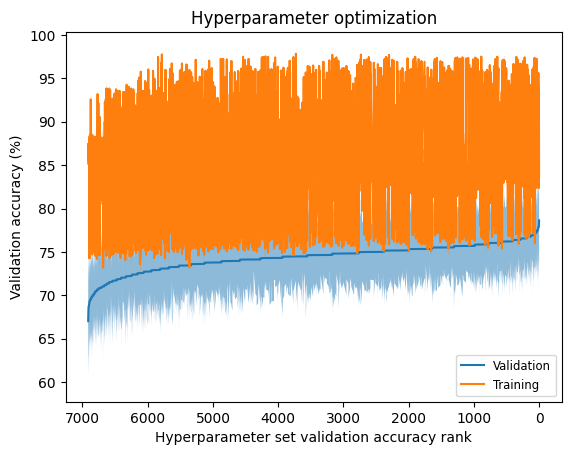

In [36]:
funcs.plot_cross_validation(search_results)

### 4.3. Cross-validation of optimized model

In [37]:
scores=cross_val_score(
    model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=7,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['Optimized']*len(scores))
cross_val_scores['Score'].extend(scores)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 75.5 +/- 3.5%


## 5. Evaluation

### 5.1. Model comparison

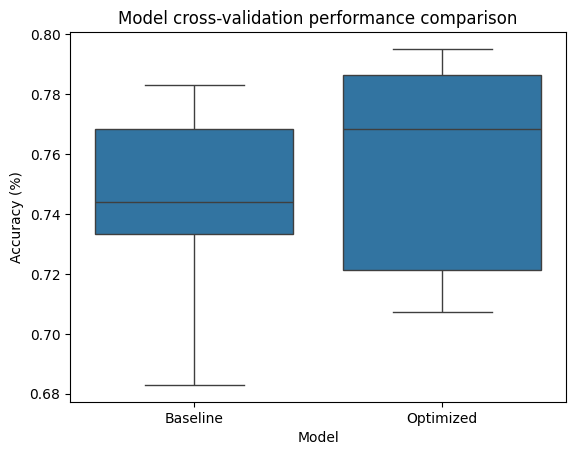

In [38]:
sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.title('Model cross-validation performance comparison')
plt.ylabel('Accuracy (%)')
plt.show()

### 5.2. Test set performance

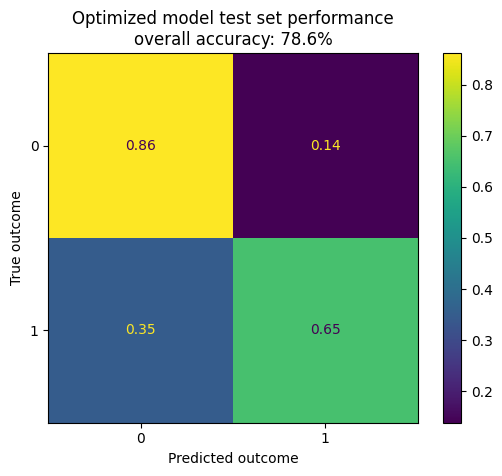

In [39]:
testing_predictions=model.predict(testing_df.drop('Outcome', axis=1))
accuracy=accuracy_score(testing_predictions, testing_df['Outcome'])*100

# Plot the confusion matrix
cm=confusion_matrix(testing_df['Outcome'], testing_predictions, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
_=cm_disp.plot()

plt.title(f'Optimized model test set performance\noverall accuracy: {accuracy:.1f}%')
plt.xlabel('Predicted outcome')
plt.ylabel('True outcome')
plt.show()

## 6. Save

### 6.1. Optimized hyperparameters

In [40]:
with open(config.RANDOM_FOREST_HYPERPARAMETERS, 'wb') as output_file:
    pickle.dump(hyperparameters, output_file)

### 6.2. Model

In [41]:
with open(config.RANDOM_FOREST_MODEL, 'wb') as output_file:
    pickle.dump(model, output_file)